In [ ]:
!pip install torchsummary
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
# model.py
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary


class DeconvMobileNet(nn.Module):
    def __init__(self, num_classes, init_weights):
        super(DeconvMobileNet, self).__init__()

        # Use the specified weights argument
        mobilenet = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        features = list(mobilenet.features.children())
        classifier = list(mobilenet.classifier.children())

        # Extracting layers from MobileNetV3
        self.conv1 = nn.Sequential(features[0])
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=0, return_indices=True)# stride 1 instead of 2

        self.conv2 = nn.Sequential(features[1], features[2], features[3])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True)# stride 1 instead of 2

        self.conv3 = nn.Sequential(features[4], features[5], features[6])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True)# stride 1 instead of 2

        self.conv4 = nn.Sequential(features[7], features[8], features[9])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True) # stride 1 instead of 2

        self.conv5 = nn.Sequential(features[10], features[11], features[12])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True) # stride 1 instead of 2

        # Conv67 layer
        self.conv67 = nn.Sequential(
            nn.Conv2d(576, 1024, kernel_size=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1000, kernel_size=(1, 1)),
            nn.BatchNorm2d(1000),
            nn.ReLU()
        )

        # Load weights for conv6 and conv7
        w_conv6 = classifier[0].state_dict()
        w_conv7 = classifier[3].state_dict()

        new_input_channels_conv6 = 96
        w_conv6_adjusted = w_conv6['weight'].unsqueeze(2).unsqueeze(3)  # .view(1024, 576, 1, 1)
        self.conv67[0].weight.data.copy_(w_conv6_adjusted)
        self.conv67[0].bias.data.copy_(w_conv6['bias'])
        self.conv67[3].weight.data.copy_(w_conv7['weight'].view(1000, 1024, 1, 1))
        self.conv67[3].bias.data.copy_(w_conv7['bias'])

        # Define deconvolution layers
        self.deconv67 = nn.Sequential(
            nn.ConvTranspose2d(1000, 1024, kernel_size=1, stride=1, padding=0),  # Mirrors conv67
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(1024, 576, kernel_size=3, stride=1, padding=1),  # Mirrors conv5
            nn.BatchNorm2d(576),
            nn.ReLU(),
            nn.ConvTranspose2d(576, 576, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(576),
            nn.ReLU(),
            nn.ConvTranspose2d(576, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU()
        )

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(96, 96, kernel_size=3, stride=1, padding=1),  # Mirrors conv4
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU()
        )

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, kernel_size=3, stride=1, padding=1),  # Mirrors conv3
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.ConvTranspose2d(40, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.ConvTranspose2d(40, 24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(24, 24, kernel_size=3, stride=1, padding=1),  # Mirrors conv2
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),  # Mirrors conv1
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=1, stride=1, padding=0)
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        original = x

        x = self.conv1(x)
        # x, p1 = self.pool1(x)

        x = self.conv2(x)
        # x, p2 = self.pool2(x)

        x = self.conv3(x)
        # x, p3 = self.pool3(x)

        x = self.conv4(x)
        # x, p4 = self.pool4(x)

        x = self.conv5(x)
        # x, p5 = self.pool5(x)

        x = self.conv67(x)
        x = self.deconv67(x)

        # x = self.unpool5(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv5(x)

        # x = self.unpool4(x, p4)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv4(x)

        # x = self.unpool3(x, p3)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv3(x)

        # x = self.unpool2(x, p2)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv2(x)

        # x = self.unpool1(x, p1)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv1(x)

        return x

    def _initialize_weights(self):
        targets = [self.conv67, self.deconv67, self.deconv5, self.deconv4, self.deconv3, self.deconv2, self.deconv1]
        for layer in targets:
            for module in layer.children():
                if isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)
                elif isinstance(module, nn.ConvTranspose2d):
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)


if __name__ == '__main__':
    # Instantiate the model
    num_classes = 21 # 20 classes + background
    model = DeconvMobileNet(num_classes=num_classes, init_weights=True)

    # Print model summary
    input_shape = (3, 224, 224)  # Adjust the input shape accordingly
    summary(model, input_size=input_shape, device='cpu')

    # Generate random input data (batch size = 1, channels = 3, height = 224, width = 224)
    input_shape = (1, 3, 224, 224)
    input_data = torch.randn(input_shape)

    # Forward pass
    wanted_output_shape = (1, num_classes, 224, 224)
    output = model(input_data)

    # Print the output shape
    assert output.size() == wanted_output_shape, f"Current output Shape is {output.size()} and should be {wanted_output_shape}"

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [ ]:
# pipeline.py
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torchvision.transforms import v2
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import random
import logging
import os
import wandb

In [ ]:
class SemanticSegmentationDataset:
    def __init__(self, root, year, image_set, batch_size=64, shuffle=True):
        # cf. https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html
        self.transform = v2.Compose([
            v2.Resize(size=256, interpolation=v2.InterpolationMode.BILINEAR),
            v2.CenterCrop(size=224),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.target_transform = v2.Compose([
            v2.Resize((224, 224), interpolation=v2.InterpolationMode.NEAREST),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        ])

        self.batch_size = batch_size
        self.color_map = {
                              0: [0, 0, 0],        # Background
                              1: [128, 0, 0],      # aeroplane
                              2: [0, 128, 0],      # bicycle
                              3: [128, 128, 0],    # bird
                              4: [0, 0, 128],      # boat
                              5: [128, 0, 128],    # bottle
                              6: [0, 128, 128],    # bus
                              7: [128, 128, 128],  # car
                              8: [64, 0, 0],       # cat
                              9: [192, 0, 0],      # chair
                              10: [64, 128, 0],    # cow
                              11: [192, 128, 0],   # diningtable
                              12: [64, 0, 128],    # dog
                              13: [192, 0, 128],   # horse
                              14: [64, 128, 128],  # motorbike
                              15: [192, 128, 128], # person
                              16: [0, 64, 0],      # potted plant
                              17: [128, 64, 0],    # sheep
                              18: [0, 192, 0],     # sofa
                              19: [128, 192, 0],   # train
                              20: [0, 64, 128],    # tv/monitor
                          }

        self.dataset = VOCSegmentation(root=root, # Root directory of the VOC Dataset
                                       year=year, # The dataset year, supports years "2007" to "2012".
                                       image_set=image_set, # Select the image_set to use
                                       download=True, # If true, downloads the dataset from the internet and puts it in root directory.
                                       transform=self.transform, # A function/transform that takes in an PIL image and returns a transformed version
                                       target_transform=self.target_transform) # A function/transform that takes in the target and transforms it.

        self.loader = DataLoader(self.dataset,
                                 batch_size=self.batch_size,
                                 shuffle=shuffle,
                                 pin_memory=True) # Move to GPU

        # Asserts
        input_shape = (self.batch_size, 3, 224, 224)
        target_shape = (self.batch_size, 1, 224, 224)
        imgs, targets = next(iter(self.loader))

        assert imgs.size() == input_shape, f"Wrong input shape, found {imgs.size()}, expected {input_shape}"
        assert targets.size() == target_shape, f"Wrong target shape, found {targets.size()}, expected {target_shape}"

    def plot(self, model):
        data_iterator = iter(self.loader)
        for _ in range(self.batch_size):
            img, target = next(data_iterator)
            prediction = model(img)
            # Display the image, ground truth, and prediction
            plt.figure(figsize=(15, 5))

            # Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(img[0].permute(1, 2, 0))
            plt.title('Input Image')
            plt.axis('off')

            # Ground Truth
            plt.subplot(1, 3, 2)
            ground_truth = target[0].squeeze()
            plt.imshow(self.colorize_mask(ground_truth))
            plt.title('Ground Truth')
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            predicted_mask = prediction[0].argmax(dim=0).cpu()
            plt.imshow(self.colorize_mask(predicted_mask))
            plt.title('Prediction')
            plt.axis('off')

            plt.show()

    def colorize_mask(mask, color_map):
        # Create an RGB image where each class has a specific color
        h, w = mask.size()
        colored_mask = np.zeros((h, w, 3), dtype=np.uint8)

        for class_idx, color in color_map.items():
            # Set pixels of the corresponding class to the color
            colored_mask[mask == class_idx] = color

        # Convert to [0, 1] float format
        colored_mask_float = colored_mask.astype(np.float32) / 255.0

        return colored_mask_float


In [ ]:
class SemanticSegmentationTrainer:
    def __init__(self, model, train_dataset, val_dataset, criterion, optimizer, num_epochs=10, patience=5, gpu_id=0):
        self.model = model
        self.model_is_best = False
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.patience = patience
        self.early_stopping_counter = 0
        self.best_val_loss = float('inf')

        self.gpu=gpu_id
        torch.cuda.set_device(self.gpu)

    def save_model_and_optimizer(self, epoch, train_loss, val_loss):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'training_loss': train_loss,
            'val_loss': val_loss
        }
        model_path = drive_path + f"checkpoint_{epoch}.pth"
        torch.save(checkpoint, model_path)

        # ... Create a Model Version
        art = wandb.Artifact(f"mobileNet-ss-{wandb.run.id}", type="model")
        # ... Add the serialized files
        art.add_file(model_path, "model.pth")
        # (optional) Log training metrics
        wandb.log({"train_loss": train_loss, "val_loss": val_loss})
        # ... Log the Version
        if self.model_is_best:
            # If the model is the best model so far,
            #  add "best" to the aliases
            wandb.log_artifact(art, aliases=["latest", "best"])
        else:
            wandb.log_artifact(art)

        print(f'Model and optimizer saved at epoch {epoch} with validation loss {val_loss}.')

    def load_model_and_optimizer(self, model, optimizer, path="checkpoint_{idx_epoch}.pth"):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        training_loss = checkpoint['training_loss']
        val_loss = checkpoint['val_loss']

        print(f'Model and optimizer saved at epoch {epoch} with validation loss {val_loss}.')

        return model, optimizer

    def early_stopping(self, val_loss):
        if val_loss < self.best_val_loss:
            self.model_is_best = True
            self.best_val_loss = val_loss
            self.early_stopping_counter = 0
        else:
            self.model_is_best = False
            self.early_stopping_counter += 1

        return self.early_stopping_counter >= self.patience

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0

            for images, targets in self.train_dataset.loader:
                batch, channels, height, width = targets.shape
                # the target tensor should have the shape (batch_size, height, width)
                targets = targets.view(batch, height, width).type(torch.LongTensor)

                # Move the tensors to the GPU, place of this line important
                # target.view seem to change the device
                images, targets = images.cuda(self.gpu, non_blocking=True), targets.cuda(self.gpu, non_blocking=True)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            avg_training_loss = total_loss / self.train_dataset.batch_size

            # Validation
            self.model.eval()
            total_val_loss = 0

            with torch.no_grad():
                for val_images, val_targets in self.val_dataset.loader:
                    batch, channels, height, width = val_targets.shape
                    # the target tensor should have the shape (batch_size, height, width)
                    val_targets = val_targets.view(batch, height, width).type(torch.LongTensor)

                    # Move the tensors to the GPU, place of this line important
                    # val_targets.view seem to change the device
                    val_images, val_targets = val_images.cuda(self.gpu, non_blocking=True), val_targets.cuda(self.gpu, non_blocking=True)

                    val_outputs = self.model(val_images)
                    val_loss = self.criterion(val_outputs, val_targets)
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / self.val_dataset.batch_size

            print(f"Epoch: {epoch}, train_loss: {avg_training_loss}, val_loss: {avg_val_loss}")
            wandb.log({"epoch": epoch, "train_loss": avg_training_loss, "val_loss": avg_val_loss})

            # Early stopping check
            if self.early_stopping(avg_val_loss):
                print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
                break

            # Save checkpoint
            self.save_model_and_optimizer(epoch,
                                          avg_training_loss,
                                          avg_val_loss)

In [ ]:
class SemanticSegmentationPipeline:
    def __init__(self, num_classes, train_batch_size, val_batch_size, num_epochs, root='./data', year='2012', gpu_id=0):
        self.root = root
        self.year = year
        self.num_classes = num_classes
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.num_epochs = num_epochs

        self.gpu=gpu_id
        torch.cuda.set_device(self.gpu)

    def run(self):
        wandb.init(
            # Set the project where this run will be logged
            project="semantic-segmentation",
            # Track hyperparameters and run metadata
            config={
                "num_classes": num_classes,
                "num_epochs": num_epochs,
                "learning_rate": lr,
                "momentum": momentum,
                "weight_decay": weight_decay,
                "train_batch_size": train_batch_size,
                "val_batch_size": val_batch_size,
            },
        )
        train_dataset = SemanticSegmentationDataset(root=self.root,
                                                    year=self.year,
                                                    image_set='train',
                                                    batch_size=self.train_batch_size,
                                                    shuffle=True)

        val_dataset = SemanticSegmentationDataset(root=self.root,
                                                  year=self.year,
                                                  image_set='val',
                                                  batch_size=self.val_batch_size,
                                                  shuffle=False)

        model = DeconvMobileNet(num_classes=self.num_classes,
                                init_weights=True).cuda(self.gpu)

        # cf. https://github.com/Jasonlee1995/DeconvNet
        criterion = nn.CrossEntropyLoss().cuda(self.gpu)
        optimizer = optim.SGD(model.parameters(),
                              lr=lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

        trainer = SemanticSegmentationTrainer(model,
                                              train_dataset,
                                              val_dataset,
                                              criterion,
                                              optimizer,
                                              self.num_epochs)

        trainer.train()

In [ ]:
if __name__ == "__main__":
    # Mount Google Drive
    drive.mount('/content/gdrive')
    # Provide the path to Google Drive directory
    drive_path = '/content/gdrive/My Drive/semantic_segmentation/checkpoint/'

    gpu_id=0

    num_classes = 21 # 20 classes + background

    num_epochs = 10

    lr = 0.01
    momentum = 0.9
    weight_decay = 0.0005

    train_batch_size = 12
    val_batch_size = 4

    wandb.login()
    pipeline = SemanticSegmentationPipeline(num_classes, train_batch_size, val_batch_size, num_epochs, gpu_id=0)
    pipeline.run()
    wandb.finish()

In [ ]:
tansform_dataset = SemanticSegmentationDataset(root='./data',
                                           year='2012',
                                           image_set='val',
                                           batch_size=5,
                                           shuffle=False)

original_dataset = VOCSegmentation(root='./data', # Root directory of the VOC Dataset
                                   year='2012', # The dataset year, supports years "2007" to "2012".
                                   image_set='val', # Select the image_set to use
                                   download=True) # If true, downloads the dataset from the internet and puts it in root directory.

# test_dataset.plot(model)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


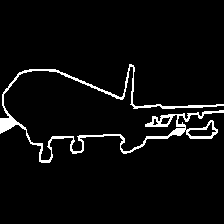

In [ ]:
v2.ToPILImage()(next(iter(tansform_dataset.loader))[1][0])

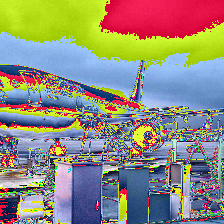

In [ ]:
v2.ToPILImage()(next(iter(tansform_dataset.loader))[0][0])

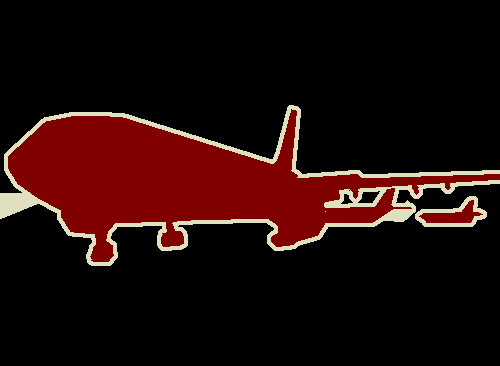

In [ ]:
next(iter(original_dataset))[1]

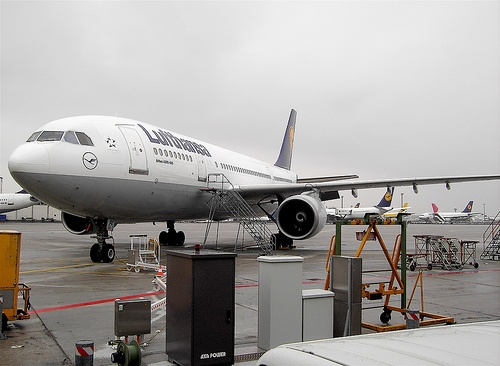

In [ ]:
next(iter(original_dataset))[0]